In [22]:
import numpy as np
import scipy as scp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from ml_utils import get_stratified_train_test_split, get_stratified_kfold_cval_splits, get_knn_A_from_B
from randomforest import RandomForest, DecisionTree

In [2]:
matplotlib.rcParams['figure.figsize'] = [20, 15]

In [3]:
datapath = "../diabetes.csv"

In [4]:
df = pd.read_csv(datapath)

In [5]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1e8f62d0>,
      dtype=object)

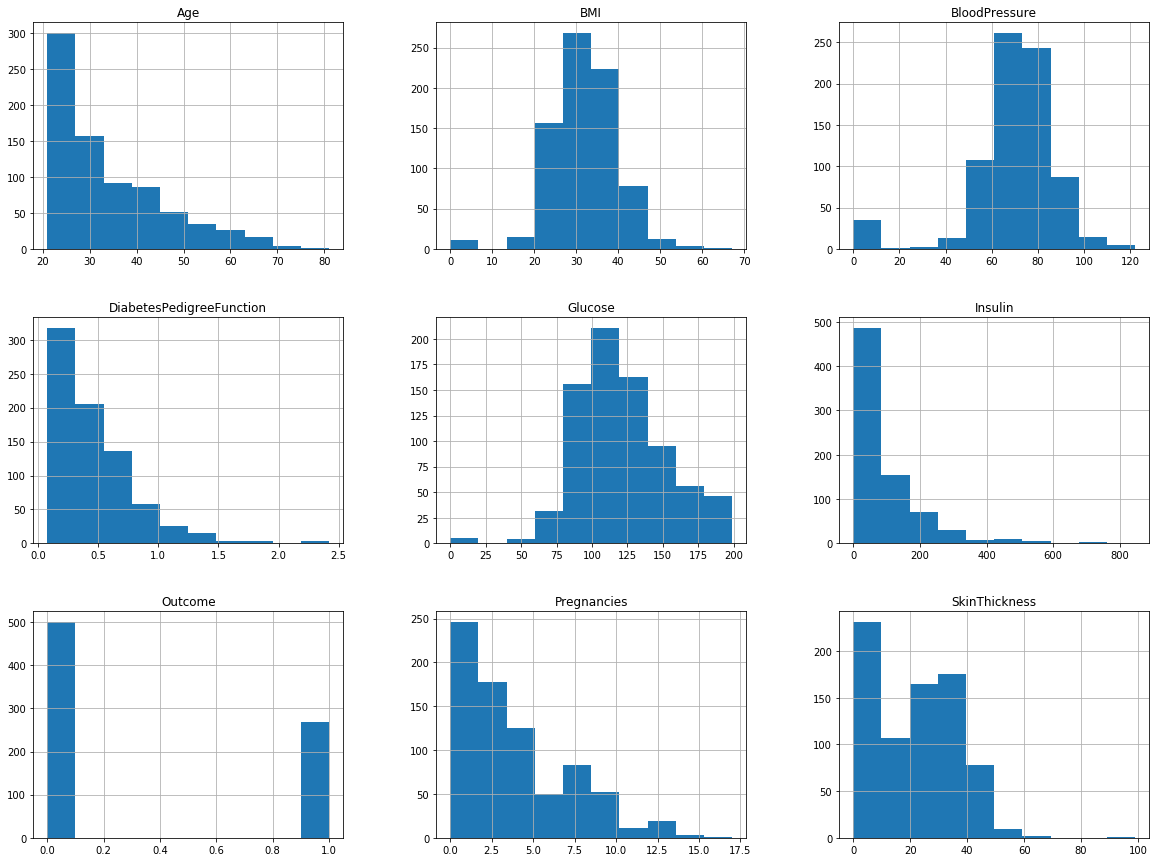

In [7]:
df.hist()


In [8]:
for colname in df.columns:
    print(colname, df[colname].isnull().sum())

Pregnancies 0
Glucose 0
BloodPressure 0
SkinThickness 0
Insulin 0
BMI 0
DiabetesPedigreeFunction 0
Age 0
Outcome 0


No NaN values; lets make sure all values are valid. 

In [9]:
for colname in df.columns:
    print(colname, sum(df[colname]==0))

Pregnancies 111
Glucose 5
BloodPressure 35
SkinThickness 227
Insulin 374
BMI 11
DiabetesPedigreeFunction 0
Age 0
Outcome 500


Handling missing values:
* Since the number of people with 0 glucose, 0 BMI, or 0 blood pressure are low, I'll remove these. Some are correlated (some patients have 0 values for multiple metrics) so this will lead to a loss of fewer than 51 data points.
* Skin thickness and insulin have a lot of zeros that don't look in line with the distribution of the non-zero values, but the distribution of pregnancies look similar (judging only from the unimodality/bimodality of the KDEs; I didn't go as far as fitting exponential and normal distributions):

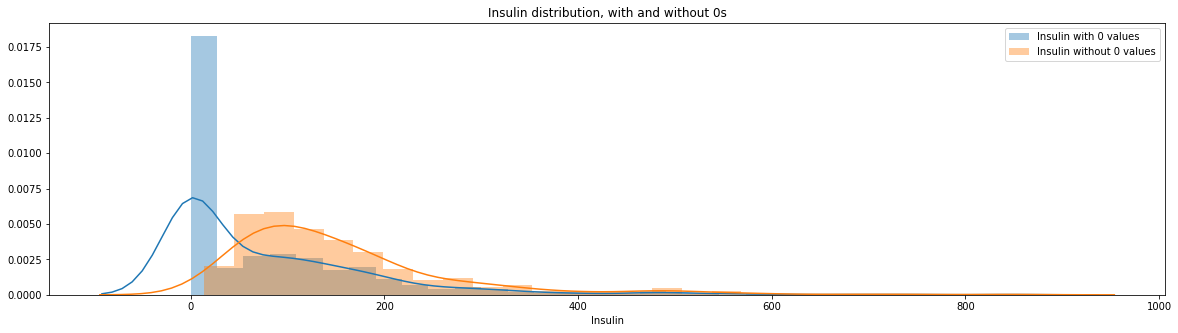

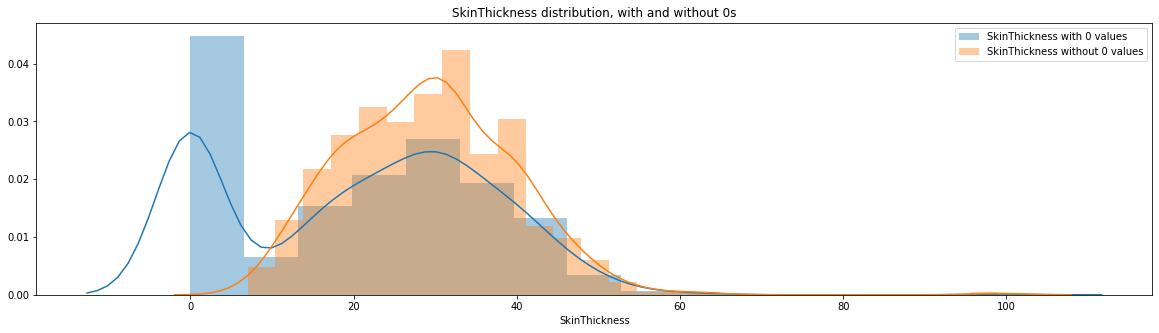

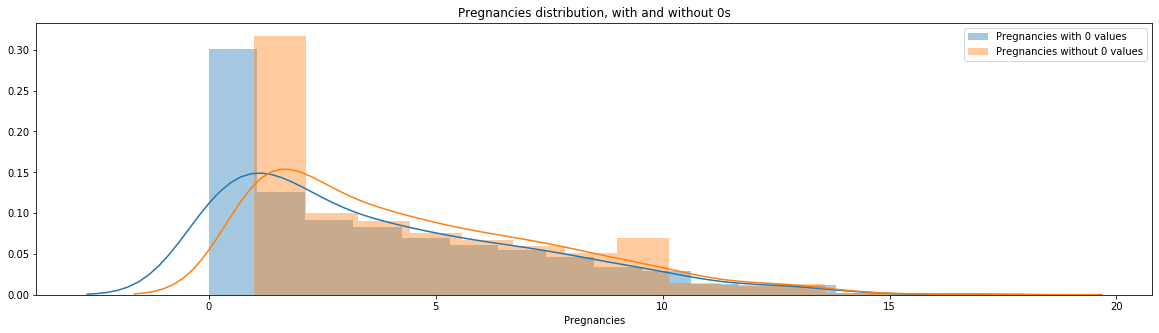

In [10]:
matplotlib.rcParams['figure.figsize'] = [20, 5]
for category in ['Insulin', 'SkinThickness', 'Pregnancies']:
    dist1 = df[category]
    dist2 = df[category][df[category]>0]
    sns.distplot(dist1)
    sns.distplot(dist2)
    plt.title(f"{category} distribution, with and without 0s");
    plt.legend([f'{category} with 0 values', f'{category} without 0 values'])
    plt.show()



Since we can't drop all of these, it's probably best to impute mean values for these. I would ideally implement a cluster-based imputation of values, but in the interest of time and to avoid data leakage I'll use the mean.

In [11]:
df['Insulin'][df['Insulin']==0] = np.mean(df['Insulin'][df['Insulin']>0])
df['SkinThickness'][df['SkinThickness']==0] = np.mean(df['SkinThickness'][df['SkinThickness']>0])

/Users/tamarmelman/opt/anaconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/tamarmelman/opt/anaconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
for colname in df.columns:
    print(colname, sum(df[colname]==0))

Pregnancies 111
Glucose 5
BloodPressure 35
SkinThickness 0
Insulin 0
BMI 11
DiabetesPedigreeFunction 0
Age 0
Outcome 500


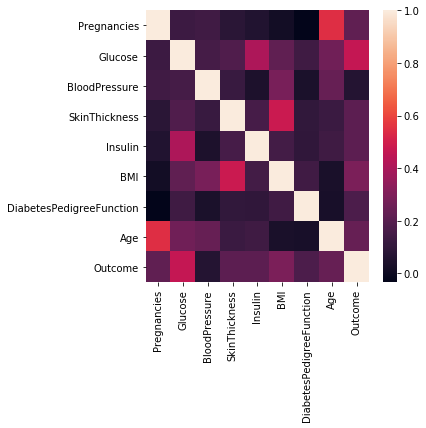

In [13]:
matplotlib.rcParams['figure.figsize'] = [5, 5]
sns.heatmap(df.corr())

In [15]:
setA = np.random.rand(30,2)
setB = np.random.rand(300,2)*2+1
k = 10
knn=get_knn_A_from_B(setA, setB,k)


In [17]:
setY = np.random.rand(10)>.5

get_stratified_train_test_split(setY, ntrain=5)

(array([2, 9, 4, 3, 5]), array([0, 1, 6, 7, 8]))

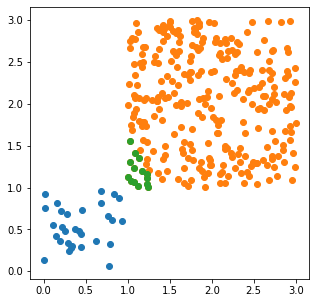

In [18]:
plt.scatter(setA[:,0], setA[:,1])
plt.scatter(setB[:,0], setB[:,1])
plt.scatter(knn[:,0], knn[:,1])

In [19]:
dfA = pd.DataFrame(columns=['a','b'], data=setA)
dfB = pd.DataFrame(columns=['a','b'], data=setB)
dfX = pd.concat((dfA, dfB))
dfY = pd.DataFrame(columns=['y'], data=np.concatenate((np.zeros(len(setA)),np.ones(len(setB))), axis=0))

In [20]:
tr,te = get_stratified_train_test_split(dfY.values, int(len(dfY)*.6))
dfX_tr = dfX.iloc[tr]
dfY_tr = dfY.iloc[tr]
dfX_te = dfX.iloc[te]
dfY_te = dfY.iloc[te]

In [23]:
dt = DecisionTree(data_x=dfX_tr, data_y=dfY_tr, max_depth=5)

In [24]:
dt.make_tree()

/Users/tamarmelman/opt/anaconda3/envs/datasci/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tamarmelman/opt/anaconda3/envs/datasci/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [26]:
predictions = []
for i in range(len(dfX_te)):
    dat = dfX_te.iloc[i]
    predictions.append(dt.predict(dat))

In [27]:
np.mean(np.array(predictions)-dfY_te.values)

0.0

In [28]:
rf = RandomForest(data_x=dfX_tr, data_y=dfY_tr)

In [29]:
rf.make_forest()

In [30]:
predictions = []
for i in range(len(dfX_te)):
    dat = dfX_te.iloc[i]
    predictions.append(rf.predict(dat))

In [31]:
np.mean(np.array(predictions)-dfY_te.values)

0.09090909090909091